In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
from google.colab import drive
import gymnasium as gym
import cv2
import matplotlib.pyplot as plt

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install gymnasium

In [ ]:
!pip install swig
!pip install gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 18.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379445 sha256=35493ef967251e9cb9f948a4537b86e0f5846dc171a48a23931acf94889e8985
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),    # -> [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),   # -> [128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # -> [256, 4, 4]
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4, latent_dim)

        self.reward_head = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 256 * 4 * 4)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1), # -> [128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),   # -> [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),    # -> [1, 64, 64]
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # standard deviation
        eps = torch.randn_like(std)    # sample from N(0,1)
        return mu + std * eps          # z = mu + sigma * epsilon

    def decode(self, z):
        x = self.fc_decode(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        reward_pred = self.reward_head(z)
        return x_recon, mu, logvar, reward_pred

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
latent_dim = 32
vae = VAE(latent_dim).to(device)
vae.load_state_dict(torch.load("/content/drive/MyDrive/vae_car_racing_newloss2.pth", map_location=device))
vae.eval()
print("VAE loaded.")

<ipython-input-6-8b7ece458292>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load("/content/drive/MyDrive/vae_car_racing.pth", map_location=devi

VAE loaded.


In [ ]:

DISCRETE_ACTIONS = [
    np.array([0.0, 0.8, 0.0]),
    np.array([-0.4, 0.8, 0.0]),
    np.array([-0.6, 0.6, 0.0]),
    np.array([-0.8, 0.4, 0.0]),
    np.array([0.4, 0.8, 0.0]),
    np.array([0.6, 0.6, 0.0]),
    np.array([0.8, 0.4, 0.0]),
    np.array([-0.2, 0.4, 0.0]),
    np.array([0.2, 0.4, 0.0]),
    np.array([0.0, 0.4, 0.0]),
    np.array([0.0, 0.0, 0.6]),
    np.array([0.0, 0.0, 0.8]),
    np.array([0.0, 0.0, 0.0])
]

num_actions = len(DISCRETE_ACTIONS)

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim=32, output_dim=num_actions):          # z to num_action. (linear layer),
        super(QNetwork, self).__init__()                               # policy learn garna ko lagi, linear layer halna parena.
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )
    def forward(self, x):
        return self.fc(x)

In [ ]:
q_main = QNetwork(input_dim=latent_dim, output_dim=num_actions).to(device)
q_target = QNetwork(input_dim=latent_dim, output_dim=num_actions).to(device)
q_target.load_state_dict(q_main.state_dict())

optimizer = optim.Adam(q_main.parameters(), lr=1e-3)

In [ ]:
#replay buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.array, zip(*batch))
        return state, action, reward, next_state, done
    def __len__(self):
        return len(self.buffer)

buffer = ReplayBuffer(capacity=50000)


In [ ]:

def preprocess_frame(frame, size=(64, 64)):
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, size, interpolation=cv2.INTER_AREA)
    frame = frame / 255.0
    return frame.astype(np.float32)

In [ ]:

def select_action(state_latent, epsilon):
    if random.random() < epsilon:
        return random.randrange(num_actions)
    with torch.no_grad():
        q_values = q_main(state_latent)
    return q_values.argmax().item()

In [ ]:
#DDQN
def update_model(batch_size=64, gamma=0.99):
    if len(buffer) < batch_size:
        return
    states, actions, rewards, next_states, dones = buffer.sample(batch_size)

    states      = torch.tensor(states, dtype=torch.float32).to(device)
    actions     = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards     = torch.tensor(rewards, dtype=torch.float32).to(device)
    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
    dones       = torch.tensor(dones, dtype=torch.float32).to(device)

    q_values = q_main(states)
    q_value = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)


    next_q_values = q_main(next_states)
    next_actions = next_q_values.argmax(1, keepdim=True)
    next_q_target = q_target(next_states).gather(1, next_actions).squeeze(1)

    expected_q = rewards + gamma * next_q_target * (1 - dones)

    loss = nn.MSELoss()(q_value, expected_q.detach())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [ ]:

env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
num_episodes = 400
max_steps = 600
epsilon_start = 1.0
epsilon_final = 0.1
epsilon_decay = 300
update_target_every = 1000
step_count = 0
all_rewards = []

for episode in range(1, num_episodes+1):
    obs, _ = env.reset()
    obs_proc = preprocess_frame(obs)
    #(batch, channel, H, W)
    obs_tensor = torch.tensor(obs_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        state_latent,_ = vae.encode(obs_tensor)
        state_latent = state_latent.squeeze(0)
    total_reward = 0.0
    done = False

    for t in range(max_steps):
        epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1.0 * step_count/epsilon_decay)
        state_latent_input = state_latent.unsqueeze(0)
        action_idx = select_action(state_latent_input, epsilon)
        action = DISCRETE_ACTIONS[action_idx]

        next_obs, reward, done, truncated, _ = env.step(action)
        next_obs_proc = preprocess_frame(next_obs)
        next_obs_tensor = torch.tensor(next_obs_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            next_state_latent,_ = vae.encode(next_obs_tensor)
            next_state_latent = next_state_latent.squeeze(0)

        buffer.push(state_latent.cpu().numpy(), action_idx, reward, next_state_latent.cpu().numpy(), done)

        state_latent = next_state_latent
        total_reward += reward
        step_count += 1

        update_model(batch_size=64, gamma=0.99)

        # Update target network
        if step_count % update_target_every == 0:
            q_target.load_state_dict(q_main.state_dict())

        if done:
            break

    all_rewards.append(total_reward)
    print(f"Episode {episode}, Reward: {total_reward:.2f}, Epsilon: {epsilon:.3f}")

env.close()

torch.save(q_main.state_dict(), "/content/drive/MyDrive/dqn_policy_car_racing_V.pth")
print("Learned policy saved to /content/drive/MyDrive/dqn_policy_car_racing_V.pth")

Episode 1, Reward: 32.94, Epsilon: 0.222
Episode 2, Reward: 36.49, Epsilon: 0.117
Episode 3, Reward: -22.41, Epsilon: 0.102
Episode 4, Reward: -22.50, Epsilon: 0.100
Episode 5, Reward: -36.12, Epsilon: 0.100
Episode 6, Reward: -31.43, Epsilon: 0.100
Episode 7, Reward: 14.47, Epsilon: 0.100
Episode 8, Reward: -13.89, Epsilon: 0.100
Episode 9, Reward: 11.70, Epsilon: 0.100
Episode 10, Reward: 27.66, Epsilon: 0.100
Episode 11, Reward: 8.84, Epsilon: 0.100
Episode 12, Reward: 106.02, Epsilon: 0.100
Episode 13, Reward: 15.09, Epsilon: 0.100
Episode 14, Reward: -10.76, Epsilon: 0.100
Episode 15, Reward: 38.31, Epsilon: 0.100
Episode 16, Reward: -4.81, Epsilon: 0.100
Episode 17, Reward: 21.40, Epsilon: 0.100
Episode 18, Reward: -2.45, Epsilon: 0.100
Episode 19, Reward: -22.07, Epsilon: 0.100
Episode 20, Reward: -106.32, Epsilon: 0.100
Episode 21, Reward: 15.99, Epsilon: 0.100
Episode 22, Reward: 20.99, Epsilon: 0.100
Episode 23, Reward: -4.64, Epsilon: 0.100
Episode 24, Reward: 22.76, Epsilon

In [ ]:
# env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
# num_test_episodes = 5

# for ep in range(num_test_episodes):
#     obs, _ = env.reset()
#     obs_proc = preprocess_frame(obs)
#     obs_tensor = torch.tensor(obs_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
#     with torch.no_grad():
#         state_latent,_ = vae.encode(obs_tensor)
#         state_latent = state_latent.squeeze(0)  # (latent_dim,)

#     frames = []
#     total_reward = 0
#     done = False
#     while not done:
#         # Use greedy policy (epsilon=0)
#         state_latent_input = state_latent.unsqueeze(0)
#         with torch.no_grad():
#             q_values = q_main(state_latent_input)
#         action_idx = q_values.argmax().item()
#         action = DISCRETE_ACTIONS[action_idx]

#         next_obs, reward, done, truncated, _ = env.step(action)
#         total_reward += reward
#         frames.append(next_obs)

#         next_obs_proc = preprocess_frame(next_obs)
#         next_obs_tensor = torch.tensor(next_obs_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
#         with torch.no_grad():
#             state_latent,_ = vae.encode(next_obs_tensor)
#             state_latent = state_latent.squeeze(0)  # (latent_dim,)

#     print(f"Test Episode {ep+1}, Total Reward: {total_reward:.2f}")

#     # Optional: Display a few frames from the episode.
#     fig, axs = plt.subplots(1, 5, figsize=(15,3))
#     for i, ax in enumerate(axs):
#         idx = int(i * len(frames)/5)
#         ax.imshow(frames[idx])
#         ax.axis("off")
#     plt.show()

# env.close()

In [ ]:
q_net = QNetwork(input_dim=latent_dim, output_dim=5).to(device)
q_net.load_state_dict(torch.load("/content/drive/MyDrive/dqn_policy_car_racing1.pth", map_location=device))
q_net.eval()
# env = gym.make("CarRacing-v3", continuous=True, render_mode="human")
# obs, _ = env.reset()
# done = False

# while not done:
#     # Preprocess observation & extract latent state (using only mu)
#     obs_proc = preprocess_frame(obs)
#     obs_tensor = torch.tensor(obs_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
#     with torch.no_grad():
#         state_latent, _ = vae.encode(obs_tensor)  # Only mu is used
#         state_latent = state_latent.squeeze(0)

#     # Select action greedily from the Q-network
#     with torch.no_grad():
#         q_values = q_net(state_latent.unsqueeze(0))
#     action_idx = q_values.argmax().item()
#     action = DISCRETE_ACTIONS[action_idx]

#     # Step in the environment
#     obs, reward, done, truncated, info = env.step(action)


<ipython-input-16-28e0df2e03d7>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  q_net.load_state_dict(torch.load("/content/drive/MyDrive/dqn_policy_car_racing1.pth", map_lo

KeyboardInterrupt: 

In [ ]:
env = gym.make("CarRacing-v3", continuous=True, render_mode="rgb_array")
frames = []
obs, _ = env.reset()
done = False

while not done:
    obs_proc = preprocess_frame(obs)
    obs_tensor = torch.tensor(obs_proc, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
    with torch.no_grad():
        state_latent, _ = vae.encode(obs_tensor)
        state_latent = state_latent.squeeze(0)
    with torch.no_grad():
        q_values = q_net(state_latent.unsqueeze(0))
    action_idx = q_values.argmax().item()
    action = DISCRETE_ACTIONS[action_idx]

    obs, reward, done, truncated, _ = env.step(action)
    frames.append(obs)
env.close()

KeyboardInterrupt: 

41795


In [ ]:
# from IPython.display import HTML, display
# import cv2
# import base64

# def display_video(frames, fps=30):
#     # Use only the first 1000 frames
#     frames = frames[:1000]
#     height, width, _ = frames[0].shape
#     out = cv2.VideoWriter('temp_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
#     for frame in frames:
#         out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
#     out.release()
#     with open('temp_video.mp4', 'rb') as f:
#         mp4 = f.read()
#     data_url = "data:video/mp4;base64," + base64.b64encode(mp4).decode()
#     return HTML(f'<video width="600" controls autoplay loop src="{data_url}"></video>')

# video_html = display_video(frames)
# display(video_html)


In [ ]:
# from IPython.display import Video, display
# import cv2

# def create_and_display_video(frames, fps=30, max_frames=1000, filename="temp_video.mp4"):
#     # Use only the first max_frames frames
#     frames = frames[:max_frames]
#     height, width, _ = frames[0].shape
#     fourcc = cv2.VideoWriter_fourcc(*'mp4v')
#     video_writer = cv2.VideoWriter(filename, fourcc, fps, (width, height))

#     for frame in frames:
#         # Convert from RGB to BGR (OpenCV expects BGR)
#         video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
#     video_writer.release()

#     display(Video(filename, embed=True, width=600, height=400))

# # Call the function with your frames list
# create_and_display_video(frames)


In [ ]:
frames = frames[:1000]

In [ ]:
print(len(frames))

1000


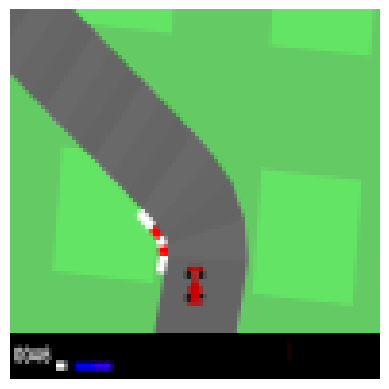

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(frames[100])
plt.axis('off')
plt.show()

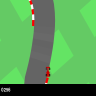

KeyboardInterrupt: 

In [ ]:
from IPython.display import clear_output, display
import PIL.Image
import time

def display_frames_as_animation(frames, fps=30):
    interval = 1/fps

    for frame in frames:
        clear_output(wait=True)
        img = PIL.Image.fromarray(frame)
        display(img)
        time.sleep(interval)

display_frames_as_animation(frames, fps=30)

In [ ]:
##############vs code ma nai herxu result, fuck